In [9]:
import preprocessing as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import pos_tag, word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def load_data(full = True):
    """
    Loads the Twitter data.
    
    Args:
    full (bool): if False, loads only a part of the data
    
    Returns:
    tweets (pandas dataframe): positive and negative tweets with labels
    test_data: unlabelled data for testing
    """
    FULL = ''  
    if full:
        FULL = '_full'
        
    POS_TWEETS = 'train_pos.txt'
    NEG_TWEETS = 'train_neg.txt'
    TEST_DATA = 'test_data.txt'
    
    with open(POS_TWEETS) as file:
        pos_tweets_data = [line.rstrip() for line in file]
    pos_tweets = pd.DataFrame(pos_tweets_data, columns=['body'])
    pos_tweets['label'] = 1

    with open(NEG_TWEETS) as file:
        neg_tweets_data = [line.rstrip() for line in file]
    neg_tweets = pd.DataFrame(neg_tweets_data, columns=['body'])
    neg_tweets['label'] = -1

    with open(TEST_DATA) as file:
        # removes id at the same time
        test_data = [line.rstrip().split(',', 1)[1] for line in file]

    test_data = pd.DataFrame(test_data, columns=['body'])

    # merge positive and negative datasets
    tweets = pd.concat([pos_tweets, neg_tweets], axis = 0)
    
    return tweets, test_data

tweets_raw, test_data_raw = load_data(full = False)

tweets_raw

,body,label
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
99995,can't wait to fake tan tonight ! hate being pale,-1
99996,<user> darling i lost my internet connection ....,-1
99997,kanguru defender basic 4 gb usb 2.0 flash driv...,-1
99998,rizan is sad now,-1


In [10]:
tweets = tweets_raw.copy()
# tweets['body'] = pp.preprocess_data(tweets['body'])
print(tweets)

                                                    body  label
0      <user> i dunno justin read my mention or not ....      1
1      because your logic is so dumb , i won't even c...      1
2      " <user> just put casper in a box ! " looved t...      1
3      <user> <user> thanks sir > > don't trip lil ma...      1
4      visiting my brother tmr is the bestest birthda...      1
...                                                  ...    ...
99995   can't wait to fake tan tonight ! hate being pale     -1
99996  <user> darling i lost my internet connection ....     -1
99997  kanguru defender basic 4 gb usb 2.0 flash driv...     -1
99998                                   rizan is sad now     -1
99999                        no text back ? yea , he mad     -1

[200000 rows x 2 columns]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer = 'char', ngram_range=(1,4), min_df = 1, max_features = 50000)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [12]:
X = tweets["body"]
y = tweets["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#bow
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)
#tf-idf
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [13]:
# logreg using tfidf
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

alphas = np.logspace(-8, -3, 15)

print("%7s | %19s | %17s " % ("Lambda","Validation accuracy","Training accuracy"))
    
for a in alphas: 
    clf_pre = SGDClassifier(loss = 'log', alpha = a, random_state=0, n_jobs=-1, verbose=False).fit(X_train_tfidf, y_train)
    print("%7.5f | %19.4f | %17.4f" % (a, 
                                       clf_pre.score(X_test_tfidf, y_test), 
                                       clf_pre.score(X_train_tfidf, y_train)))

 Lambda | Validation accuracy | Training accuracy 
0.00000 |              0.7960 |            0.9240
0.00000 |              0.8031 |            0.9171
0.00000 |              0.8135 |            0.9160
0.00000 |              0.8235 |            0.9073
0.00000 |              0.8273 |            0.9000
0.00000 |              0.8321 |            0.8901
0.00000 |              0.8357 |            0.8796
0.00000 |              0.8361 |            0.8678
0.00001 |              0.8328 |            0.8551
0.00002 |              0.8279 |            0.8431
0.00004 |              0.8175 |            0.8278
0.00008 |              0.8026 |            0.8099
0.00019 |              0.7855 |            0.7896
0.00044 |              0.7616 |            0.7651
0.00100 |              0.7388 |            0.7409


In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
confusion_matrix(y_test, clf_pre.predict(X_test_tfidf))

array([[14672,  5415],
       [ 5033, 14880]])

In [15]:
# random forest using tf-idf
n_estimators = [50, 150, 300]

In [16]:
train_res_pre = []
val_res_pre = []

print("%7s | %19s | %17s | %9s" % ("N","Validation accuracy","Training accuracy", "Max depth"))

for n in n_estimators:
    rf_pre = RandomForestClassifier(n_estimators=n, 
                                    n_jobs=-1, 
                                    random_state=0,
                                    verbose=False).fit(X_train_tfidf, y_train)
    print("%7.0f | %19.4f | %17.4f | %9.0f" % (n, 
                                       rf_pre.score(X_test_tfidf, y_test), 
                                       rf_pre.score(X_train_tfidf, y_train),
                                       max([x.tree_.max_depth for x in rf_pre.estimators_])))
    
    fpr, tpr, _ = roc_curve(y_train, rf_pre.predict(X_train_tfidf))
    roc_auc = auc(fpr,tpr)
    train_res_pre.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(y_test, rf_pre.predict(X_test_tfidf))
    roc_auc = auc(fpr,tpr)
    val_res_pre.append(roc_auc)

      N | Validation accuracy | Training accuracy | Max depth
     50 |              0.8069 |            0.9999 |       370
    150 |              0.8136 |            0.9999 |       405
    300 |              0.8146 |            0.9999 |       415


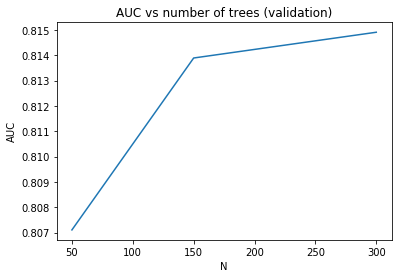

In [17]:
plt.plot(n_estimators, val_res_pre)
plt.ylabel('AUC')
plt.xlabel('N')
plt.title('AUC vs number of trees (validation)')
plt.show()

In [18]:
# tune max_depth
from sklearn.ensemble import RandomForestClassifier

max_depths = np.linspace(10, 100, 10)

print("%9s | %19s | %17s " % ("Max depth","Validation accuracy","Training accuracy"))

for d in max_depths:
    rf_pre = RandomForestClassifier(n_estimators=150, 
                                     max_depth=d,
                                     n_jobs=-1, 
                                     random_state=0,
                                     verbose=False).fit(X_train_tfidf, y_train)
    print("%9.0f | %19.4f | %17.4f" % (d, 
                                       rf_pre.score(X_test_tfidf, y_test), 
                                       rf_pre.score(X_train_tfidf, y_train)))

Max depth | Validation accuracy | Training accuracy 
       10 |              0.7204 |            0.7315
       20 |              0.7661 |            0.8254
       30 |              0.7897 |            0.9059
       40 |              0.8004 |            0.9530
       50 |              0.8065 |            0.9768
       60 |              0.8076 |            0.9883
       70 |              0.8101 |            0.9940
       80 |              0.8114 |            0.9969
       90 |              0.8117 |            0.9983
      100 |              0.8122 |            0.9992


In [19]:
# svm using tfidf
alphas = np.logspace(-7, -3, 12)

print("%7s | %19s | %17s " % ("Alpha","Validation accuracy","Training accuracy"))
    
for a in alphas: 
    svm_pre = SGDClassifier(loss = 'hinge', alpha = a, random_state=0, n_jobs=-1, verbose=False).fit(X_train_tfidf, y_train)
    print("%7.5f | %19.4f | %17.4f" % (a, 
                                       svm_pre.score(X_test_tfidf, y_test), 
                                       svm_pre.score(X_train_tfidf, y_train)))

  Alpha | Validation accuracy | Training accuracy 
0.00000 |              0.8141 |            0.9199
0.00000 |              0.8230 |            0.9158
0.00000 |              0.8283 |            0.9074
0.00000 |              0.8316 |            0.8951
0.00000 |              0.8350 |            0.8842
0.00001 |              0.8373 |            0.8712
0.00002 |              0.8362 |            0.8599
0.00004 |              0.8299 |            0.8453
0.00008 |              0.8218 |            0.8324
0.00019 |              0.8083 |            0.8144
0.00043 |              0.7899 |            0.7943
0.00100 |              0.7653 |            0.7686


In [20]:
# logreg using bow
alphas = np.logspace(-6, -3, 15)

print("%7s | %19s | %17s " % ("Lambda","Validation accuracy","Training accuracy"))
    
for a in alphas: 
    clf_bow = SGDClassifier(loss = 'log', alpha = a, random_state=0, n_jobs=-1, verbose=False).fit(X_train_counts, y_train)
    print("%7.5f | %19.4f | %17.4f" % (a, 
                                       clf_bow.score(X_test_counts, y_test), 
                                       clf_bow.score(X_train_counts, y_train)))

 Lambda | Validation accuracy | Training accuracy 
0.00000 |              0.7890 |            0.8883
0.00000 |              0.7977 |            0.8904
0.00000 |              0.7948 |            0.8644
0.00000 |              0.8013 |            0.8613
0.00001 |              0.8079 |            0.8616
0.00001 |              0.8055 |            0.8510
0.00002 |              0.8050 |            0.8379
0.00003 |              0.8062 |            0.8356
0.00005 |              0.8027 |            0.8271
0.00008 |              0.8002 |            0.8203
0.00014 |              0.7957 |            0.8112
0.00023 |              0.7909 |            0.8034
0.00037 |              0.7869 |            0.7963
0.00061 |              0.7797 |            0.7868
0.00100 |              0.7728 |            0.7778


In [21]:
# random forest using bow
train_res_bow = []
val_res_bow = []

print("%7s | %19s | %17s | %9s" % ("N","Validation accuracy","Training accuracy", "Max depth"))

for n in n_estimators:
    rf_bow = RandomForestClassifier(n_estimators=n, 
                                    n_jobs=-1, 
                                    random_state=0,
                                    verbose=False).fit(X_train_counts, y_train)
    print("%7.0f | %19.4f | %17.4f | %9.0f" % (n, 
                                       rf_bow.score(X_test_counts, y_test), 
                                       rf_bow.score(X_train_counts, y_train),
                                       max([x.tree_.max_depth for x in rf_bow.estimators_])))
    
    fpr2, tpr2, _ = roc_curve(y_train, rf_bow.predict(X_train_counts))
    roc_auc2 = auc(fpr2,tpr2)
    train_res_bow.append(roc_auc2)
    
    fpr2, tpr2, _ = roc_curve(y_test, rf_bow.predict(X_test_counts))
    roc_auc2 = auc(fpr2,tpr2)
    val_res_bow.append(roc_auc2)

      N | Validation accuracy | Training accuracy | Max depth
     50 |              0.8067 |            0.9995 |      1671
    150 |              0.8120 |            0.9995 |      1737
    300 |              0.8135 |            0.9995 |      1737


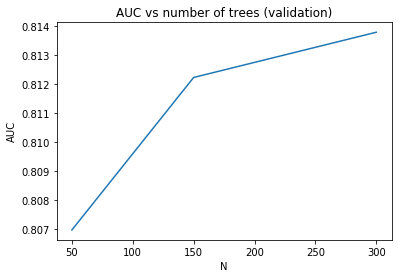

In [22]:
plt.plot(n_estimators, val_res_bow)
plt.ylabel('AUC')
plt.xlabel('N')
plt.title('AUC vs number of trees (validation)')
plt.show()

In [23]:
# tune max_depth
max_depths = np.linspace(10, 100, 10)

print("%9s | %19s | %17s " % ("Max depth","Validation accuracy","Training accuracy"))

for d in max_depths:
    rf_bow = RandomForestClassifier(n_estimators=150, 
                                     max_depth=d,
                                     n_jobs=-1, 
                                     random_state=0,
                                     verbose=False).fit(X_train_counts, y_train)
    print("%9.0f | %19.4f | %17.4f" % (d, 
                                       rf_bow.score(X_test_counts, y_test), 
                                       rf_bow.score(X_train_counts, y_train)))

Max depth | Validation accuracy | Training accuracy 
       10 |              0.7172 |            0.7265
       20 |              0.7302 |            0.7484
       30 |              0.7350 |            0.7597
       40 |              0.7459 |            0.7817
       50 |              0.7475 |            0.7960
       60 |              0.7539 |            0.8144
       70 |              0.7597 |            0.8340
       80 |              0.7651 |            0.8508
       90 |              0.7727 |            0.8683
      100 |              0.7750 |            0.8808


In [24]:
# svm using bow
alphas = np.logspace(-6, -3, 12)

print("%7s | %19s | %17s " % ("Alpha","Validation accuracy","Training accuracy"))

for a in alphas: 
    svm_bow = SGDClassifier(loss = 'hinge', alpha = a, random_state=0, n_jobs=-1, verbose=False).fit(X_train_counts, y_train)
    print("%7.5f | %19.4f | %17.4f" % (a, 
                                       svm_bow.score(X_test_counts, y_test), 
                                       svm_bow.score(X_train_counts, y_train)))

  Alpha | Validation accuracy | Training accuracy 
0.00000 |              0.7815 |            0.8935
0.00000 |              0.7930 |            0.9021
0.00000 |              0.7913 |            0.8899
0.00001 |              0.8025 |            0.8875
0.00001 |              0.8055 |            0.8755
0.00002 |              0.8025 |            0.8528
0.00004 |              0.8087 |            0.8493
0.00008 |              0.8023 |            0.8315
0.00015 |              0.7999 |            0.8227
0.00028 |              0.7949 |            0.8120
0.00053 |              0.7875 |            0.8000
0.00100 |              0.7789 |            0.7882
